## Class 2 - Defining evaluation metrics and fitting basic regression models
In our second lecture, we discussed a number of algorithms and evaluation metrics for regression problems. Today, we will go back to the datasets we looked at last week, and implement some of these algorithms and evaluation metrics on the predictive modeling problems we have defined. 

We will do all of this using `scikit-learn`. A couple of useful pointers to useful documentation, before we start:
- In general, the scikit-learn documentation is your friend: https://scikit-learn.org/stable/
- Here is a list of linear models implemented as Extractors/Predictors in sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
- Here are different forms of neighbor-based models (we talked about `KNNRegressor` yesterday)
- Here are evaluation metrics implemented in sklearn: https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics 
- Here are utilities for preprocessing steps: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing 

**Note**: Under `nbs/class_02` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on simulated data.

### Today's exercise
Gather in the same or similar groups as last week. Under `class/class_02.md` you will find two predictive modeling questions, one for each datasets. There are different variants of the same questions, which differ in which outcome you want to predict.

What I would like you to do today is the following:
1. Create a folder called `group-x` within `nbs/class_02`, `cd` into it and work within that today
2. Choose an outcome variable for a regression problem. On the basis of this, define **which of the evaluation metrics** could be suitable. Evaluation metrics can be computed using scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics 
3. (a) If you are in the bike sharing group, split your dataset into a training/validation/test set using later time points as validation/test set. Validation and test set should be 15% of your data each. (b) If you are in the personality group, using sklearn's `train_test_split` function, create a 70/15/15 random split of your data.
    - Remember to set a seed (`random_state`) when you do so. Let's all use the same (the classic `random_state=42`)
    - Save these datasets as separate csv files in a subfolder called `data`
4. Look at your outcome and predictors: do you want to transform them in any way?
5. Estimate the performance of a dummy baseline (i.e., the mean model) on all splits
6. Now look at your predictors: do they need any preprocessing? Any transformations? Removal of "bad" data points?
7. Fit the other models using KKN (sklearn's `KNeighborsRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and linear models (`LinearRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Save the fitted model object (with a meaningful name) using `pickle` (https://scikit-learn.org/stable/model_persistence.html) in a subfolder called `model`.
8. Once you are done, evaluate all models on both the training and the validation set and visualize the scores


### Once you have done this
Please submit a pull request to my repository where, within `nbs/class_02/group-x` you have: 
- the notebook on which you have worked
- a subfolder called `data` containing your splits
- a subfolder called `models` containing your models

In next week's class, I will ask each group to briefly present their results.

In [93]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

In [94]:
# load the data
data = pd.read_csv("../../../../../Project Files/data/class_01/bikes.csv")

In [95]:
# look at the data
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Choosing an Evaluation Metric
Based on the fact that we are interested in doing prediction, we are not going to evaluate based on R2. Instead, we opt for Mean Absolute Error as that is more suitable for seeing if our model predicts data well.

In [96]:
# creating the y and X for all models
y = np.array(data["cnt"])
X0 = np.ones(len(y)).reshape(-1,1)
X1 = np.array(data["instant"]).reshape(-1,1)
X2 = np.array(data[["temp", "windspeed", "season", "weekday"]])
X3 = np.array(data[["instant", "season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed"]])

Xs = [X0, X1, X2, X3]

In [97]:
# split the data into train, test and val

# find the points that fit with where the data should be split to get 70/15/15
first_70 = int(len(data) * 0.70)
next_15 = int(len(data) * 0.15 + first_70)

# set empty lists
train_Xs = []
val_Xs = []
test_Xs = []

# fill the lists
for X in Xs:
    # get the train
    train = X[:first_70]
    train_Xs.append(train)

    # get the val
    val = X[first_70:next_15]
    val_Xs.append(val)

    # get the test
    test = X[next_15:]
    test_Xs.append(test)


y_train = y[:first_70]
y_val = y[first_70:next_15]
y_test = y[next_15:]

print(len(train_Xs[0]))
print(len(val_Xs[0]))
print(len(test_Xs[0]))

print(len(y_train))
print(len(y_val))
print(len(y_test))

12165
2606
2608
12165
2606
2608


<Axes: xlabel='cnt', ylabel='Count'>

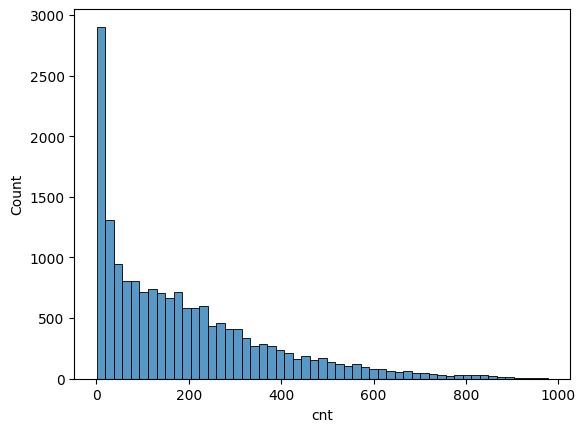

In [98]:
# looking at the distribution of the outcome
sns.histplot(data=data, x="cnt")

### Create and Evaluate Models for Linear Regression

In [99]:

# init list for evals
eval_mae = []

# fit the models
for i in range(len(Xs)):
    # initialize the model
    model = LinearRegression()

    # fit model on the training data
    model.fit(train_Xs[i], y_train)

    # predict on the validation
    X_predict = model.predict(val_Xs[i])

    # evaluate the predictions
    mae = round(mean_absolute_error(X_predict, y_val),2)

    # append score
    eval_mae.append(mae)

    # save model to subfolder
    pkl.dump(model, file=open(f'model/linear-X{i}.pkl', 'wb'))

    print(f"Validation MAE score for Linear Regression on X{i}: {mae}")


Validation MAE score for Linear Regression on X0: 194.08
Validation MAE score for Linear Regression on X1: 179.66
Validation MAE score for Linear Regression on X2: 166.05
Validation MAE score for Linear Regression on X3: 155.34


### Create and Evaluate Models for KNN Regression

In [100]:
# repeat the process for KNN regression
# init list for evals
eval_mae = []

# fit the models
for i in range(len(Xs)):
    # initialize the model (10 neighbors)
    model = KNeighborsRegressor(n_neighbors=10)

    # fit model on the training data
    model.fit(train_Xs[i], y_train)

    # predict on the validation
    X_predict = model.predict(val_Xs[i])

    # evaluate the predictions
    mae = round(mean_absolute_error(X_predict, y_val),2)

    # save model to subfolder
    pkl.dump(model, file=open(f'model/knn-X{i}.pkl', 'wb'))

    # append score
    eval_mae.append(mae)

    print(f"Validation MAE score for KNN Regression on X{i}: {mae}")

Validation MAE score for KNN Regression on X0: 270.14
Validation MAE score for KNN Regression on X1: 181.26
Validation MAE score for KNN Regression on X2: 164.53
Validation MAE score for KNN Regression on X3: 181.47


Based on the MAE scores, the KNN regression for X2 (Using some but not all variables) performed the best on the evaluation data. Therefore we proceed to evaluate it on the test data.

In [101]:
# load the best model
best_model = pkl.load(open('model/knn-X2.pkl', 'rb'))

# evaluate on test data
X_predict = model.predict(test_Xs[i])

mae = round(mean_absolute_error(X_predict, y_test),2)

print(f"Test MAE score for KNN Regression on X2: {mae}")

Test MAE score for KNN Regression on X2: 184.03


### Today's exercise
Gather in the same group as last week, and please go through the following steps:
1. Look back at last week's notebook. If you have not applied any transformation to your input because you did not have time, spend some time thinking about whether it would make sense to do so. You can find relevant transformations in `scikit-learn`: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. You will probably mostly be interested in `StandardScaler` and `MinMaxScaler`
2. Look at the performance of the models you've fitted last week: what is the best model? Do you see any evidence of overfitting?
3. Fit your maximal models with `Lasso` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) and `Ridge` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) estimators instead of `LinearRegression`. Make sure you look at the documentation to understand what these do. Fit multiple models with multiple values of alpha and store the outputs;
4. Plot the performance of your models against your linear and KNN models from last week. Does the performance of the model on the validation set improve with regularization?
5. For both `Lasso` and `Ridge` models, plot the value of the coefficients as a function of alpha. You can access the coefficients for a fitted `model` through `model.coef_`. What do you notice in terms of how LASSO versus Ridge behave? (Look at `example.ipynb` for inspiration)
6. Finally, if any models are doing better than the linear model without regularization, select the best `Ridge` and the best `Lasso` model, and plot their coefficients, alongsize coefficients from the simple linear models. How do estimates change with regularization? Which values have changed the most? Do you have any hypothesis as to why?

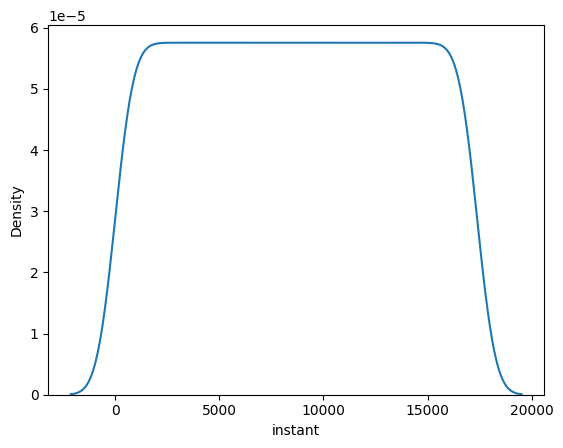

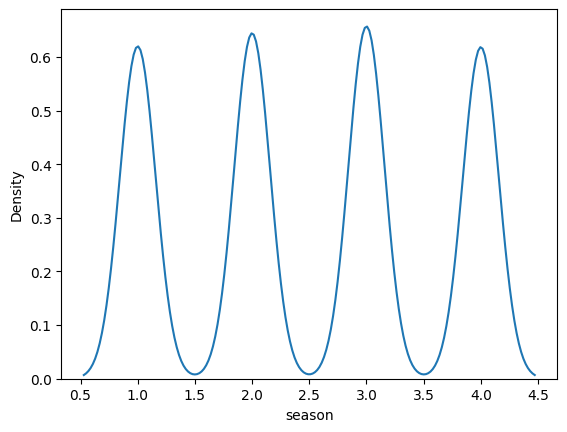

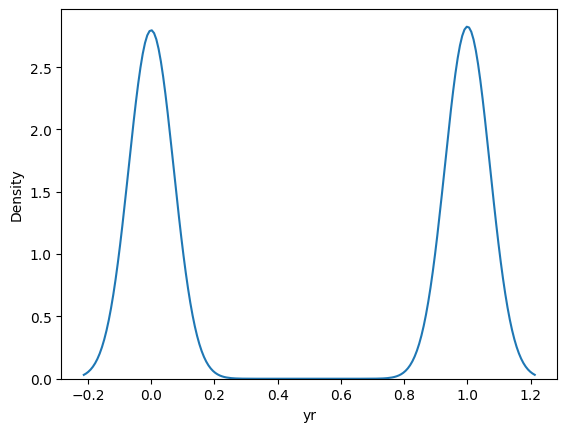

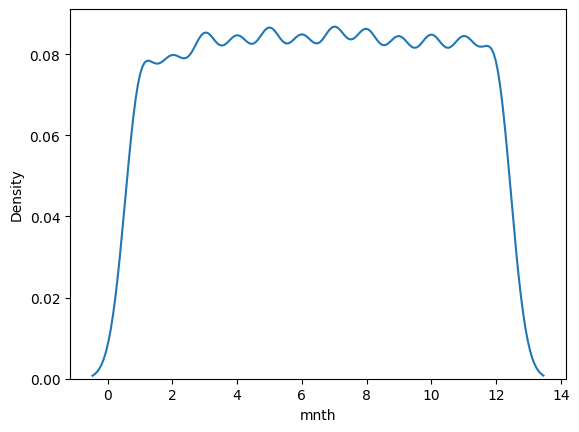

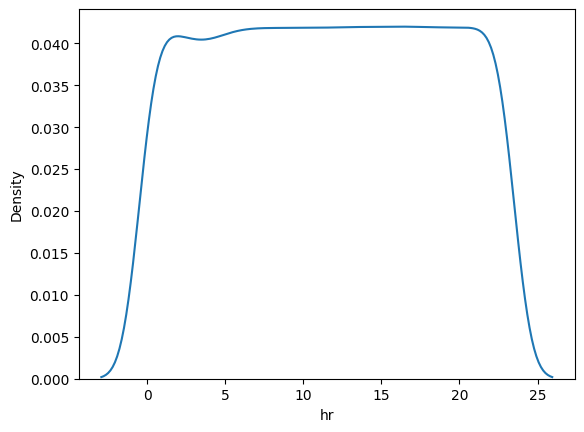

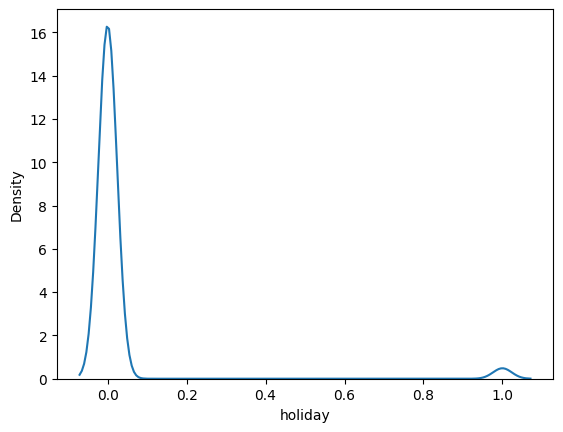

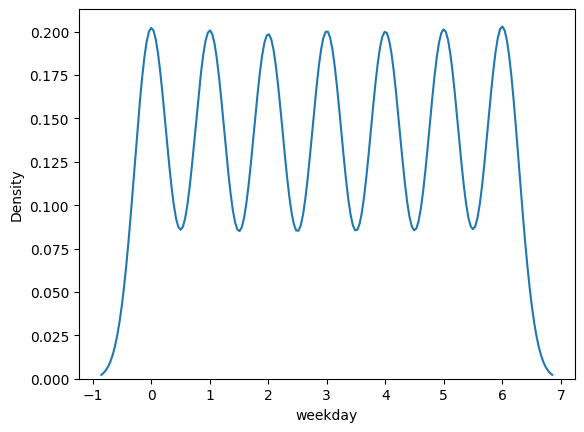

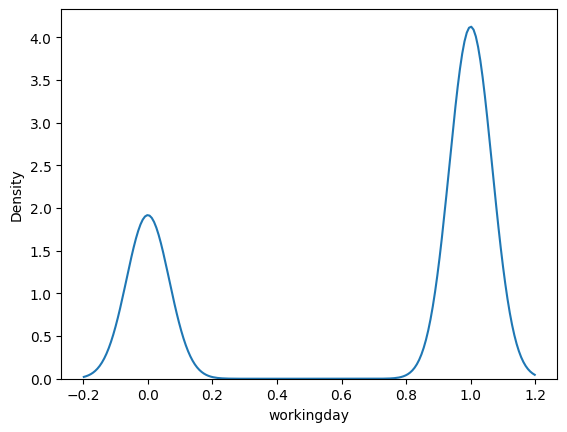

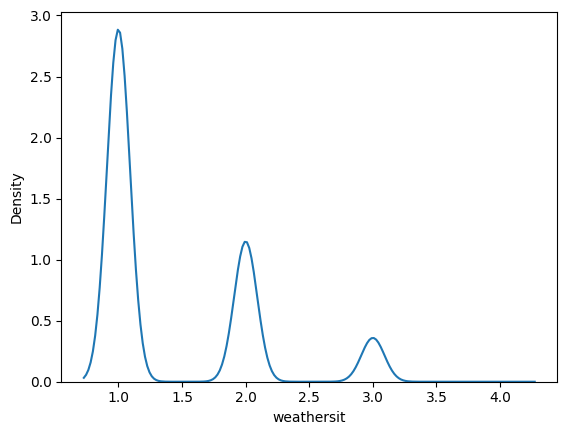

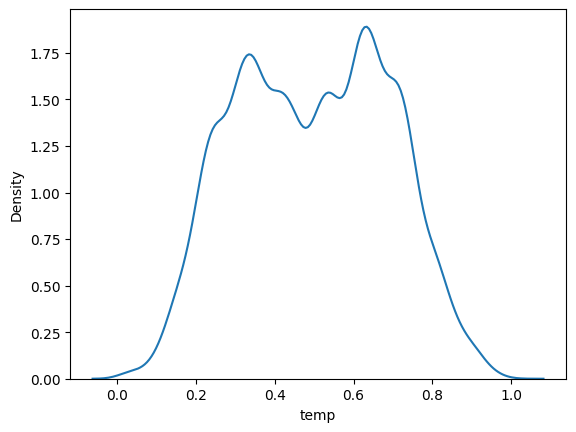

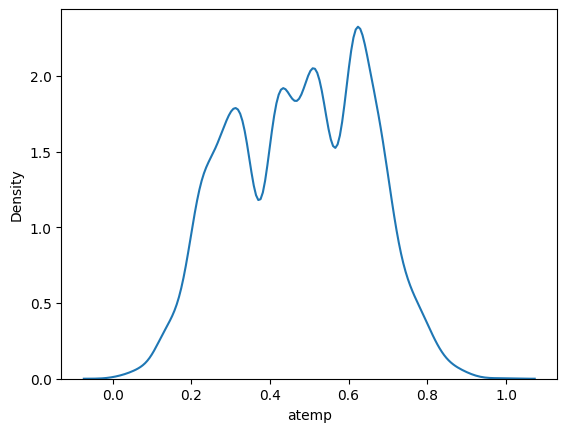

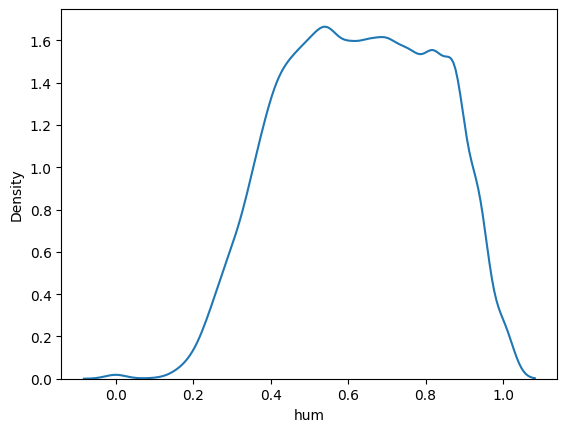

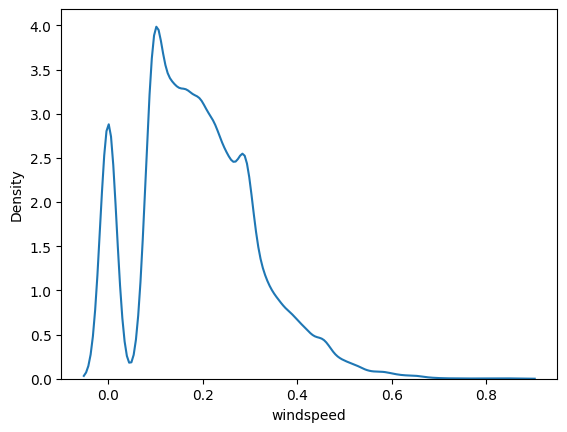

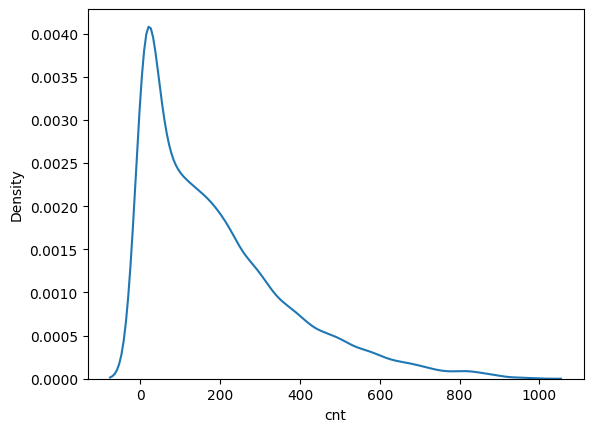

In [102]:
list_of_predictors = ["instant", "season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed", "cnt"]

for predictor in list_of_predictors:
    plt.figure()
    sns.kdeplot(data=data, x=predictor)
    

Count looks very skewed so we try to scale that. The other ones are already normalized or categorialized.

In [103]:
# creating the y and X for all models
y = np.array(data["cnt"])

# scale the y variable from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.reshape(-1,1)).reshape(-1)

# split into train, val and test again
y_train = y[:first_70]
y_val = y[first_70:next_15]
y_test = y[next_15:]

In [125]:
alphas = [0.01, 0.1, 1, 5, 10, 25, 50, 100, 200, 300, 400, 500, 1000, 2500, 5000, 10000]
lasso_mae = []
ridge_mae = []

for alpha in alphas:
    # init model
    lasso_model = linear_model.Lasso(alpha=alpha)
    ridge_model = linear_model.Ridge(alpha=alpha)

    # fit model
    lasso_model.fit(train_Xs[2], y_train)
    ridge_model.fit(train_Xs[2], y_train)

    # predict on the validation
    X_predict_lasso = lasso_model.predict(val_Xs[2])
    X_predict_ridge = ridge_model.predict(val_Xs[2])

    # evaluate the predictions
    mae_lasso = round(mean_absolute_error(X_predict_lasso, y_val),2)
    mae_ridge = round(mean_absolute_error(X_predict_ridge, y_val),2)

    lasso_mae.append(mae_lasso)
    ridge_mae.append(mae_ridge)

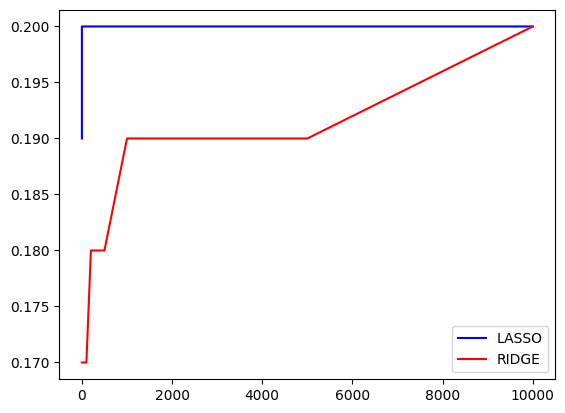

In [126]:
plt.Figure()
plt.plot(alphas, lasso_mae, color = "blue")
plt.plot(alphas, ridge_mae, color = "red")
plt.legend(labels = ["LASSO", "RIDGE"])

In [123]:
ridge_model.coef_

array([0.01288987, 0.00240544, 0.00866458, 0.00151209])

In [124]:
lasso_model.coef_

array([0., 0., 0., 0.])